In [2]:
import numpy as np
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import time
import os
import pandas as pd
import sklearn.decomposition
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
np.random.seed(0)
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import seaborn as sns
sns.set_theme(style='ticks', palette='bright', font='sans-serif', font_scale=1.2)

from rdkit import Chem

Instructions for updating:
non-resource variables are not supported in the long term


In [55]:
############################################################
####################
TRAINING_STEPS = 20000 #50000
embedding_dim = 64 #depth of 1D conv matrix
batch_size = 64
learning_rate = .0001
zdim = 32 #size of gaussian noise
nfilt = 64 #width of convolutions and layers
MAX_LENGTH = 128 #max length of conditions
NULL_TOKEN = '~'

####################
############################################################

In [3]:
#load the relevant datasets
Dataset1_Smiles_P = pd.read_csv("dataset1_imputed_all.csv")
Dataset2 = pd.read_csv("dataset2.csv")
Dataset2 = Dataset2[~Dataset2['Smiles'].str.contains('L')]
Dataset3 = pd.read_csv("dataset3.csv")

,Unnamed: 0,index,Name,PID,Smiles,Details,Condition,Reference,Year,He,...,log10_O2_Bayesian,log10_N2_Bayesian,log10_CO2_Bayesian,log10_CH4_Bayesian,log10_He_Etree,log10_H2_Etree,log10_O2_Etree,log10_N2_Etree,log10_CO2_Etree,log10_CH4_Etree
0,0,0,polyethene,P010001,*C*,Dynamic method,"25 [C] ,","Pasternak, R. A.; Schimscheimer, J. F.; Heller...",1970,NaN,...,0.531479,-0.075721,1.110590,0.012254,1.201301,1.238196,0.531479,-0.075721,1.110590,-0.103039
1,1,1,polyethene,P010001,*C*,Dynamic method,"25 [C] ,","Pasternak, R. A.; Schimscheimer, J. F.; Heller...",1970,NaN,...,0.429002,-0.191294,1.037426,-0.101212,0.512792,0.845879,0.372675,-0.111720,1.037426,0.361122
2,2,2,polyethene,P010001,*C*,"Mocon Oxtran 100 equipment; P.S. Holden, G. A....","30 [C] ,","Holden, P. S.; Orchard, G. A. J.; Ward, I. M. ...",1985,NaN,...,-0.665546,-1.367414,-0.066764,-1.348410,0.803205,0.693273,-0.665546,-1.412270,-0.130830,-1.517954
3,3,3,polyethene,P010001,*C*,"Mocon Oxtran 100 equipment; P.S. Holden, G. A....","30 [C] ,","Holden, P. S.; Orchard, G. A. J.; Ward, I. M. ...",1985,NaN,...,-0.327902,-1.004516,0.274628,-0.963282,0.696047,0.613919,-0.327902,-1.146430,0.327439,-1.337536
4,4,4,polyethene,P010001,*C*,NaN,"25 [C] ,","Holden, P. S.; Orchard, G. A. J.; Ward, I. M. ...",1985,1.77,...,-0.013228,-0.490133,0.826281,-0.003425,0.247973,0.794222,-0.013228,-0.606161,0.774200,-0.306994
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
773,773,313,Poly(2-adamanthyl vinyl ether),NaN,*CC(*)OC1C2CC3CC(C2)CC1C3,Vinyl and Vinylidene Polymers,NaN,http://dx.doi.org/10.1002/app.30834,2009,NaN,...,0.778874,0.227887,1.401401,0.360861,1.035338,1.350877,0.778874,0.227887,1.401401,0.498163
774,774,314,Poly(benzyl vinyl ether),NaN,*CC(*)OCc1ccccc1,Vinyl and Vinylidene Polymers,NaN,http://dx.doi.org/10.1002/app.30834,2009,NaN,...,0.367356,-0.102373,1.045323,0.067094,0.506273,0.849116,0.367356,-0.102373,1.045323,0.359446
775,775,315,Poly(cyclohexylmethyl vinyl ether),NaN,*CC(*)OCC1CCCCC1,Vinyl and Vinylidene Polymers,NaN,http://dx.doi.org/10.1002/app.30834,2009,NaN,...,0.190332,-0.397940,0.770115,-0.314109,0.966260,0.943327,0.190332,-0.397940,0.770115,-0.114003
776,776,316,Poly(8-tricyclo[5.2.1.0]decylmethyl vinyl ether),NaN,*CC(*)OCC1CC2CC1C1CCCC21,Vinyl and Vinylidene Polymers,NaN,http://dx.doi.org/10.1002/app.30834,2009,NaN,...,-0.091515,-0.886057,0.454845,-0.901289,0.922455,1.046136,-0.091515,-0.886057,0.454845,-1.037802


In [7]:
all_smiles = Dataset3['SMILES']

NULL_TOKEN = '~'
END_TOKEN = '!'

V = sorted(set(''.join(all_smiles.unique().tolist())))
V.append(END_TOKEN)
V.append(NULL_TOKEN)
#V = shuffle(V, random_state=0)
vocab_dim = len(V)

['#',
 '%',
 '(',
 ')',
 '*',
 '+',
 '-',
 '/',
 '0',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 '=',
 'A',
 'B',
 'C',
 'F',
 'G',
 'H',
 'I',
 'K',
 'N',
 'O',
 'P',
 'S',
 'T',
 'Z',
 '[',
 '\\',
 ']',
 'a',
 'b',
 'c',
 'd',
 'e',
 'i',
 'l',
 'n',
 'o',
 'p',
 'r',
 's',
 '!',
 '~']

In [8]:
#tokenize the conditions for the three datasets
smiles = Dataset1_Smiles_P['Smiles']
smiles_ = [np.array([V.index(c) for c in s] + [V.index(END_TOKEN)]).astype(np.int32) for s in smiles]
smilesdf = pd.DataFrame(smiles_, index=smiles.index)
smilesdf = smilesdf.fillna(value=V.index(NULL_TOKEN))
smilesdf = smilesdf.astype('int32')

smiles2 = Dataset2['Smiles']
smiles2_ = [np.array([V.index(c) for c in s] + [V.index(END_TOKEN)]).astype(np.int32) for s in smiles2]
smilesdf2 = pd.DataFrame(smiles2_, index=smiles2.index)
smilesdf2 = smilesdf2.fillna(value=V.index(NULL_TOKEN))
smilesdf2 = smilesdf2.astype('int32')

all_smiles_ = [np.array([V.index(c) for c in s] + [V.index(END_TOKEN)]).astype(np.int32) for s in all_smiles]
allsmilesdf = pd.DataFrame(all_smiles_, index=all_smiles.index)
allsmilesdf = allsmilesdf.fillna(value=V.index(NULL_TOKEN))
allsmilesdf = allsmilesdf.astype('int32')

,0,1,2,3,4,5,6,7,8,9,...,181,182,183,184,185,186,187,188,189,190
0,4,21,4,48,49,49,49,49,49,49,...,49,49,49,49,49,49,49,49,49,49
1,4,21,4,48,49,49,49,49,49,49,...,49,49,49,49,49,49,49,49,49,49
2,4,21,4,48,49,49,49,49,49,49,...,49,49,49,49,49,49,49,49,49,49
3,4,21,4,48,49,49,49,49,49,49,...,49,49,49,49,49,49,49,49,49,49
4,4,21,4,48,49,49,49,49,49,49,...,49,49,49,49,49,49,49,49,49,49
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
773,4,21,21,2,4,3,28,21,9,21,...,49,49,49,49,49,49,49,49,49,49
774,4,21,21,2,4,3,28,21,38,9,...,49,49,49,49,49,49,49,49,49,49
775,4,21,21,2,4,3,28,21,21,9,...,49,49,49,49,49,49,49,49,49,49
776,4,21,21,2,4,3,28,21,21,9,...,49,49,49,49,49,49,49,49,49,49


In [11]:
split = False
if split:
    conditions_train, conditions_eval, expressions_train, expressions_eval = train_test_split(smilesdf, permdf, 
                                                    test_size=0.2, 
                                                    random_state=2)
else:
    conditions_train = smilesdf
    expressions_train = permdf
    conditions_eval = pd.DataFrame()
    expressions_eval = pd.DataFrame()
    
#print(conditions_train.shape)
#print(expressions_train.shape)
#print(conditions_eval.shape)
#print(expressions_eval.shape)

In [12]:
#############################################
#############################################
##### tf graph
class Loader(object):
    """A Loader class for feeding numpy matrices into tensorflow models."""

    def __init__(self, data, labels=None, shuffle=False):
        """Initialize the loader with data and optionally with labels."""
        self.start = 0
        self.epoch = 0
        self.data = [x for x in [data, labels] if x is not None]
        self.labels_given = labels is not None

        if shuffle:
            self.r = list(range(data.shape[0]))
            np.random.shuffle(self.r)
            self.data = [x[self.r] for x in self.data]

    def next_batch(self, batch_size=100):
        """Yield just the next batch."""
        num_rows = self.data[0].shape[0]

        if self.start + batch_size < num_rows:
            batch = [x[self.start:self.start + batch_size] for x in self.data]
            self.start += batch_size
        else:
            self.epoch += 1
            batch_part1 = [x[self.start:] for x in self.data]
            batch_part2 = [x[:batch_size - (x.shape[0] - self.start)] for x in self.data]
            batch = [np.concatenate([x1, x2], axis=0) for x1, x2 in zip(batch_part1, batch_part2)]

            self.start = batch_size - (num_rows - self.start)

        if not self.labels_given:  # don't return length-1 list
            return batch[0]
        else:  # return list of data and labels
            return batch

    def iter_batches(self, batch_size=100):
        """Iterate over the entire dataset in batches."""
        num_rows = self.data[0].shape[0]

        end = 0

        if batch_size > num_rows:
            if not self.labels_given:
                yield [x for x in self.data][0]
            else:
                yield [x for x in self.data]
        else:
            for i in range(num_rows // batch_size):
                start = i * batch_size
                end = (i + 1) * batch_size

                if not self.labels_given:
                    yield [x[start:end] for x in self.data][0]
                else:
                    yield [x[start:end] for x in self.data]
            if end < num_rows:
                if not self.labels_given:
                    yield [x[end:] for x in self.data][0]
                else:
                    yield [x[end:] for x in self.data]

def lrelu(x, leak=0.2, name="lrelu"):
    """Leaky ReLU activation."""
    return tf.maximum(x, leak * x)

def nameop(op, name):

    return tf.identity(op, name=name)

def minibatch(input_, num_kernels=15, kernel_dim=10, name='',):
    """Add minibatch features to input."""
    with tf.variable_scope(name):
        W = tf.get_variable('{}/Wmb'.format(name), [input_.get_shape()[-1], num_kernels * kernel_dim])
        b = tf.get_variable('{}/bmb'.format(name), [num_kernels * kernel_dim])

    x = tf.matmul(input_, W) + b
    activation = tf.reshape(x, (-1, num_kernels, kernel_dim))
    diffs = tf.expand_dims(activation, 3) - tf.expand_dims(tf.transpose(activation, [1, 2, 0]), 0)
    abs_diffs = tf.reduce_mean(tf.abs(diffs), 2)
    minibatch_features = tf.reduce_mean(tf.exp(-abs_diffs), 2)

    return tf.concat([input_, minibatch_features], axis=-1)

def build_config(limit_gpu_fraction=0.2, limit_cpu_fraction=10):
    if limit_gpu_fraction > 0:
        # os.environ["CUDA_VISIBLE_DEVICES"] = "0"
        gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=limit_gpu_fraction)
        config = tf.ConfigProto(gpu_options=gpu_options)
    else:
        os.environ["CUDA_VISIBLE_DEVICES"] = ""
        config = tf.ConfigProto(device_count={'GPU': 0})
    if limit_cpu_fraction is not None:
        if limit_cpu_fraction <= 0:
            # -2 gives all CPUs except 2
            cpu_count = min(
                1, int(os.cpu_count() + limit_cpu_fraction))
        elif limit_cpu_fraction < 1:
            # 0.5 gives 50% of available CPUs
            cpu_count = min(
                1, int(os.cpu_count() * limit_cpu_fraction))
        else:
            # 2 gives 2 CPUs
            cpu_count = int(limit_cpu_fraction)
        config.inter_op_parallelism_threads = cpu_count
        config.intra_op_parallelism_threads = cpu_count
        os.environ['OMP_NUM_THREADS'] = str(1)
        os.environ['MKL_NUM_THREADS'] = str(cpu_count)
    return config

def bn(tensor, name, is_training):
    # return tensor
    # return tf.contrib.layers.batch_norm(tensor, is_training=is_training, scale=True, decay=0.9, updates_collections=None, scope=name, reuse=tf.AUTO_REUSE)
    return tf.layers.batch_normalization(tensor,
                      momentum=.9,
                      training=is_training,
                      name=name)
    # return tf.keras.layers.BatchNormalization(momentum=.9)(tensor, is_training)

def Generator(z, cond, nfilt, outdim, activation=lrelu, is_training=True):
    h1 = tf.layers.dense(z, nfilt * 4, activation=None, name='h1')
    h1 = bn(h1, 'h1', is_training)
    h1 = activation(h1)

    h2 = tf.layers.dense(h1, nfilt * 2, activation=None, name='h2')
    h2 = bn(h2, 'h2', is_training)
    h2 = activation(h2)

    h3 = tf.layers.dense(h2, nfilt * 1, activation=None, name='h3')
    h3 = bn(h3, 'h3', is_training)
    h3 = activation(h3)

    h1_cond = tf.layers.dense(cond, nfilt * 4, activation=None, name='h1_cond')
    h1_cond = bn(h1_cond, 'h1_cond', is_training)
    h1_cond = activation(h1_cond)

    h2_cond = tf.layers.dense(h1_cond, nfilt * 2, activation=None, name='h2_cond')
    h2_cond = bn(h2_cond, 'h2_cond', is_training)
    h2_cond = activation(h2_cond)

    h3_cond = tf.layers.dense(h2_cond, nfilt * 1, activation=None, name='h3_cond')
    h3_cond = bn(h3_cond, 'h3_cond', is_training)
    h3_cond = activation(h3_cond)

    h3 = tf.concat([h3, h3_cond], axis=-1)

    h4 = tf.layers.dense(h3, nfilt * 2, activation=None, name='h4')
    h4 = bn(h4, 'h4', is_training)
    h4 = lrelu(h4)
    h4 = tf.concat([h4, h2, h2_cond], axis=-1)

    h5 = tf.layers.dense(h4, nfilt * 4, activation=None, name='h5')
    h5 = bn(h5, 'h5', is_training)
    h5 = lrelu(h5)
    h5 = tf.concat([h5, h1, h1_cond], axis=-1)

    out = tf.layers.dense(h5, outdim, activation=None, name='out')

    return out

def Embedder(x, nfilt, outdim, activation=lrelu, is_training=True):
    h1 = tf.layers.dense(x, nfilt * 4, activation=None, name='h1')
    h1 = bn(h1, 'h1', is_training)
    h1 = activation(h1)

    h2 = tf.layers.dense(h1, nfilt * 2, activation=None, name='h2')
    h2 = bn(h2, 'h2', is_training)
    h2 = activation(h2)

    h3 = tf.layers.dense(h2, nfilt * 1, activation=None, name='h3')
    h3 = bn(h3, 'h3', is_training)
    h3 = activation(h3)

    out = tf.layers.dense(h3, outdim, activation=None, name='out')

    return out

def Discriminator(x, cond, nfilt, outdim, activation=lrelu, is_training=True):
    h1 = tf.layers.dense(x, nfilt * 8, activation=None, name='h1')
    h1 = activation(h1)
    h1 = minibatch(h1)

    h1_cond = tf.layers.dense(cond, nfilt * 8, activation=None, name='h1_cond')
    h1_cond = activation(h1_cond)
    h1_cond = minibatch(h1_cond)

    h1 = tf.concat([h1, h1_cond], axis=-1)

    h2 = tf.layers.dense(h1, nfilt * 4, activation=None, name='h2')
    h2 = bn(h2, 'h2', is_training)
    h2 = activation(h2)

    h3 = tf.layers.dense(h2, nfilt * 2, activation=None, name='h3')
    h3 = bn(h3, 'h3', is_training)
    h3 = activation(h3)

    h4 = tf.layers.dense(h3, nfilt * 1, activation=None, name='h4')
    h4 = bn(h4, 'h4', is_training)
    h4 = activation(h4)

    out = tf.layers.dense(h4, outdim, activation=None, name='out')

    return out

def adversarial_loss(logits, labels):
    return tf.nn.sigmoid_cross_entropy_with_logits(logits=logits, labels=labels)
    # return tf.reduce_mean((logits - labels)**2)

def preprocess_batch(batch_x, batch_cond):
    batch_max_size = MAX_LENGTH
    batch_cond = batch_cond[:, :batch_max_size]
    batch_cond = np.where(np.isnan(batch_cond), V.index(NULL_TOKEN), batch_cond)

    return batch_x, batch_cond

def calculate_mmd_(k1, k2, k12):
    return k1.sum() / (k1.shape[0] * k1.shape[1]) + k2.sum() / (k2.shape[0] * k2.shape[1]) - 2 * k12.sum() / (k12.shape[0] * k12.shape[1])

def calculate_mmd(dist1, dist2):
    k1 = sklearn.metrics.pairwise.pairwise_distances(dist1, dist1)
    k2 = sklearn.metrics.pairwise.pairwise_distances(dist2, dist2)
    k12 = sklearn.metrics.pairwise.pairwise_distances(dist1, dist2)
    mmd = 0
    for sigma in [.01, .1, 1., 10.]:
        k1_ = np.exp(-k1 / sigma**2)
        k2_ = np.exp(-k2 / sigma**2)
        k12_ = np.exp(-k12 / sigma**2)
        mmd += calculate_mmd_(k1_, k2_, k12_)
    return mmd

In [13]:
####################
############################################################
#reduces the dimension of the predictive variables to 15 dimensions, no necessary for gas permeability (6 dimensions)
reducedim = False

if reducedim:
    pcadim = 15
    pca = sklearn.decomposition.PCA(pcadim)
    pca.fit(np.concatenate([expressions_train, expressions_eval], axis=0))
    pcadata_train = pca.transform(expressions_train)
    pcadata_eval = pca.transform(expressions_eval)
    loadtrain = Loader(pcadata_train, conditions_train.values, shuffle=True)
    loadtrain_unshuffled = Loader(pcadata_train, conditions_train.values, shuffle=False)
    loadeval = Loader(pcadata_eval, conditions_eval.values, shuffle=False)
else:
    loadtrain = Loader(expressions_train.values, conditions_train.values, shuffle=True)
    loadtrain_unshuffled = Loader(expressions_train.values, conditions_train.values, shuffle=False)
    loadeval = Loader(expressions_eval.values, conditions_eval.values, shuffle=False)
outdim = loadtrain.data[0].shape[1]


#############################################
#############################################

In [14]:
tf.reset_default_graph()
tfis_training = tf.placeholder(tf.bool, [], name='tfis_training')


G_mult = 1
D_mult = 4
##################################################

condition = tf.placeholder(tf.int32, [None, MAX_LENGTH], name='condition')

#embed the generator condition
embedding_G = tf.Variable(tf.random_normal((vocab_dim, embedding_dim), 0, .1), name='generator/embedding')
embedding_input_G = tf.nn.embedding_lookup(embedding_G, condition)
with tf.variable_scope('generator_condition', reuse=tf.AUTO_REUSE):
    h1 = tf.layers.conv1d(embedding_input_G, 64 * G_mult, 3, strides=4, padding='same', name='conv1')
    h1 = bn(h1, 'conv1', tfis_training)
    h1 = lrelu(h1)

    h2 = tf.layers.conv1d(h1, 32 * G_mult, 3, strides=4, padding='same', name='conv2')
    h2 = bn(h2, 'conv2', tfis_training)
    h2 = lrelu(h2)

    h3 = tf.layers.conv1d(h2, 16 * G_mult, 3, strides=4, padding='same', name='conv3')
    h3 = bn(h3, 'conv3', tfis_training)
    h3 = lrelu(h3)

    pre_embedding_condition_G = tf.reshape(h3, [tf.shape(h3)[0], MAX_LENGTH // 64 * 16 * G_mult])

    embedded_condition_G = Embedder(pre_embedding_condition_G, nfilt * G_mult, outdim=128, is_training=tfis_training)
    embedded_condition_G = nameop(embedded_condition_G, 'embedded_condition_G')

#embed the discriminator condition
embedding_D = tf.Variable(tf.random_normal((vocab_dim, embedding_dim), 0, .1), name='discriminator/embedding')
embedding_input_D = tf.nn.embedding_lookup(embedding_D, condition)
with tf.variable_scope('discriminator_condition', reuse=tf.AUTO_REUSE):
    h1 = tf.layers.conv1d(embedding_input_D, 64 * D_mult, 3, strides=4, padding='same', name='conv1')
    h1 = bn(h1, 'conv1', tfis_training)
    h1 = lrelu(h1)

    h2 = tf.layers.conv1d(h1, 32 * D_mult, 3, strides=4, padding='same', name='conv2')
    h2 = bn(h2, 'conv2', tfis_training)
    h2 = lrelu(h2)

    h3 = tf.layers.conv1d(h2, 16 * D_mult, 3, strides=4, padding='same', name='conv3')
    h3 = bn(h3, 'conv3', tfis_training)
    h3 = lrelu(h3)

    pre_embedding_condition_D = tf.reshape(h3, [tf.shape(h3)[0], MAX_LENGTH // 64 * 16 * D_mult])

    embedded_condition_D = Embedder(pre_embedding_condition_D, nfilt * D_mult, outdim=128, is_training=tfis_training)
    embedded_condition_D = nameop(embedded_condition_D, 'embedded_condition_D')

##################################################

C:\Users\jason\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\keras\legacy_tf_layers\convolutional.py:202: UserWarning: `tf.layers.conv1d` is deprecated and will be removed in a future version. Please Use `tf.keras.layers.Conv1D` instead.
  warnings.warn('`tf.layers.conv1d` is deprecated and '
C:\Users\jason\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1719: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '
C:\Users\jason\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\keras\legacy_tf_layers\normalization.py:308: UserWarning: `tf.layers.batch_normalization` is deprecated and will be removed in a future version. Please use `tf.keras.layers.BatchNormalization` instead. In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.

In [15]:
##################################################
#forward propogate to calculate the loss in the discriminator and generator
z = tf.placeholder(tf.float32, [None, zdim], name='z')

with tf.variable_scope('generator', reuse=tf.AUTO_REUSE):
    G = Generator(z, embedded_condition_G, nfilt * G_mult, outdim, is_training=tfis_training)
    G = nameop(G, 'G')

x = tf.placeholder(tf.float32, [None, outdim], name='x')
with tf.variable_scope('discriminator', reuse=tf.AUTO_REUSE):
    real = Discriminator(x, embedded_condition_D, nfilt=nfilt * D_mult, outdim=1, is_training=tfis_training)
    fake = Discriminator(G, embedded_condition_D, nfilt=nfilt * D_mult, outdim=1, is_training=tfis_training)

loss_D = .5 * tf.reduce_mean(adversarial_loss(logits=real, labels=tf.ones_like(real)))
loss_D += .5 * tf.reduce_mean(adversarial_loss(logits=fake, labels=tf.zeros_like(fake)))
loss_G = tf.reduce_mean(adversarial_loss(logits=fake, labels=tf.ones_like(fake)))

update_ops_D = [op for op in tf.get_collection(tf.GraphKeys.UPDATE_OPS) if 'discriminator' in op.name]
update_ops_G = [op for op in tf.get_collection(tf.GraphKeys.UPDATE_OPS) if 'generator' in op.name]

print('update ops G: {}'.format(len(update_ops_G)))
print('update ops D: {}'.format(len(update_ops_D)))

#train with the adam optimizer for gradient descent
with tf.control_dependencies(update_ops_D):
    optD = tf.train.AdamOptimizer(learning_rate)
    train_op_D = optD.minimize(loss_D, var_list=[tv for tv in tf.trainable_variables() if 'discriminator' in tv.name])
with tf.control_dependencies(update_ops_G):
    optG = tf.train.AdamOptimizer(learning_rate)
    train_op_G = optG.minimize(loss_G, var_list=[tv for tv in tf.trainable_variables() if 'generator' in tv.name])
##################################################

update ops G: 28
update ops D: 24


In [16]:
##################################################


#use the config that was built above in this class, and the defined graph structure
sess = tf.Session(config=build_config(limit_gpu_fraction=.1))

#initialize tensorflow session once with the variables that were defined
sess.run(tf.global_variables_initializer())


#############################################

In [17]:
#############################################

#loop through the training with a predefined number of steps
t = time.time()
training_counter = 0
MMDs = []
mmd = 1

while training_counter < TRAINING_STEPS + 1 and mmd > 0.02:
    training_counter += 1
    batch_x, batch_cond = loadtrain.next_batch(batch_size)
    batchz = np.random.normal(0, 1, [batch_size, zdim])

    batch_x, batch_cond_ = preprocess_batch(batch_x, batch_cond)

    feed = {x: batch_x, condition: batch_cond_, z: batchz, tfis_training: True}
    #run the tensorflow training optimizers on the generator and discriminator
    sess.run(train_op_G, feed_dict=feed)
    sess.run(train_op_D, feed_dict=feed)

    #run the tensorflow training based on the losses on the generator and discriminator
    if training_counter % 100 == 0:
        ld, lg = sess.run([loss_D, loss_G], feed_dict=feed)
        print("{} ({:.3f} s): LossD: {:.3f} LossG: {:.3f} ".format(training_counter, time.time() - t, ld, lg))
        t = time.time()
    
        if training_counter % 100 == 0:
            # run the given training data through the model
            # a train-test split is generally not necessary, so train generally refers to all datapoints
            traindata = [] #actual permeability data
            trainconditions = [] # conditions that accompany the permeability data
            trainpreds = [] # generated permeability data
            trainembconditions = [] # learned condition embeddings
            embGs = [] #inputs
            emb_inpGs = [] #inputs with one more step
            
            
            for i, (batch_x, batch_cond) in enumerate(loadtrain.iter_batches(batch_size)):
                batchz = np.random.normal(0, 1, [batch_x.shape[0], zdim])

                batch_x, batch_cond_ = preprocess_batch(batch_x, batch_cond)

                feed = {x: batch_x, condition: batch_cond_, z: batchz, tfis_training: False}
                #run new conditions here
                
                preds = sess.run(G, feed_dict=feed)
                embG = sess.run(embedding_G, feed_dict=feed)
                emb_inpG = sess.run(embedding_input_G, feed_dict=feed)
                embconds = sess.run(embedded_condition_G, feed_dict=feed)

                traindata.append(batch_x)
                trainconditions.append(batch_cond)
                trainpreds.append(preds)
                trainembconditions.append(embconds)
                embGs.append(embG)
                emb_inpGs.append(emb_inpG)
                
            traindata = np.concatenate(traindata, axis=0)
            trainconditions = np.concatenate(trainconditions, axis=0)
            trainpreds = np.concatenate(trainpreds, axis=0)
            trainembconditions = np.concatenate(trainembconditions, axis=0)
            embGs = np.concatenate(embGs, axis = 0)
            emb_inpGs = np.concatenate(emb_inpGs, axis = 0)
            mmd = calculate_mmd(permdf, trainpreds)
            MMDs.append(mmd)
            
            #pca = PCA(n_components=2)
            #transformed = pca.fit_transform(traindata)
            #plt.plot(transformed[:,0], transformed[:,1], '.')
            #transformed = pca.fit_transform(trainpreds)
            #plt.plot(transformed[:,0], transformed[:,1], '.')
            #plt.legend(['Actual', 'Generated'])
            #plt.show()
            
            #trainconditions_df = pd.DataFrame(trainconditions)
            #polymer_cond = smilesdf.iloc[0,:] #choose a polymer from the original dataframe, 0 index is polyethylene
            #polyeth_indices = trainconditions_df.where(trainconditions_df == polymer_cond).dropna().index

            #pca = PCA(n_components=2)
            #transformed = pca.fit_transform(traindata)
            #plt.plot(transformed[polyeth_indices,0], transformed[polyeth_indices,1], '.')
            #transformed = pca.fit_transform(trainpreds)
            #plt.plot(transformed[polyeth_indices,0], transformed[polyeth_indices,1], '.')
            #plt.legend(['Actual', 'Generated'])
            #plt.show()
            
            #permeability = traindata[polyeth_indices,-2]
            #selectivity = traindata[polyeth_indices,-2] - traindata[polyeth_indices,-1]
            #plt.plot(permeability, selectivity, '.')
            #permeability = trainpreds[polyeth_indices,-2]
            #selectivity = trainpreds[polyeth_indices,-2] - trainpreds[polyeth_indices,-1]
            #plt.plot(permeability, selectivity, '.')
            #plt.legend(['Actual', 'Generated'])
            #plt.show()

100 (23.823 s): LossD: 0.603 LossG: 0.770 
200 (20.019 s): LossD: 0.590 LossG: 0.782 
300 (19.231 s): LossD: 0.556 LossG: 0.911 
400 (19.135 s): LossD: 0.516 LossG: 0.922 
500 (19.879 s): LossD: 0.432 LossG: 1.083 
600 (20.137 s): LossD: 0.345 LossG: 1.259 
700 (20.225 s): LossD: 0.221 LossG: 1.672 
800 (19.670 s): LossD: 0.141 LossG: 1.905 
900 (21.776 s): LossD: 0.119 LossG: 2.108 
1000 (20.684 s): LossD: 0.061 LossG: 2.784 
1100 (19.961 s): LossD: 0.045 LossG: 3.191 
1200 (20.159 s): LossD: 0.040 LossG: 3.325 
1300 (19.209 s): LossD: 0.079 LossG: 3.092 
1400 (18.633 s): LossD: 0.058 LossG: 2.973 
1500 (21.003 s): LossD: 0.087 LossG: 3.208 
1600 (24.305 s): LossD: 0.043 LossG: 2.946 
1700 (23.588 s): LossD: 0.035 LossG: 3.816 
1800 (23.846 s): LossD: 0.031 LossG: 3.975 
1900 (24.555 s): LossD: 0.013 LossG: 4.384 
2000 (25.250 s): LossD: 0.011 LossG: 4.678 
2100 (28.878 s): LossD: 0.011 LossG: 4.520 
2200 (30.442 s): LossD: 0.009 LossG: 4.726 
2300 (27.729 s): LossD: 0.014 LossG: 4.92

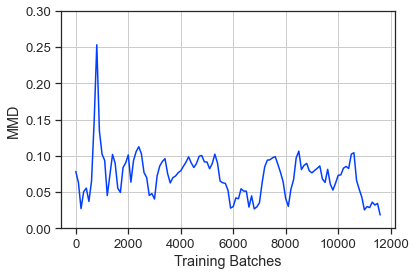

In [75]:
#plot the MMD loss history
sns.set_theme(style='ticks', palette='bright', font='sans-serif', font_scale=1.2)
fig = plt.figure()
plt.plot(np.arange(len(MMDs))*100, MMDs)
plt.ylabel('MMD')
plt.xlabel('Training Batches')
plt.ylim([0, 0.3])
plt.grid()
fig.savefig('MMD_loss.svg', format='svg')

0       4
1      21
2      21
3      28
4      21
       ..
186    49
187    49
188    49
189    49
190    49
Name: 363, Length: 191, dtype: int32
0       4
1      28
2      38
3       9
4      38
       ..
186    49
187    49
188    49
189    49
190    49
Name: 690, Length: 191, dtype: int32


C:\Users\jason\Anaconda3\envs\my-rdkit-env\lib\site-packages\ipykernel_launcher.py:126: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
C:\Users\jason\Anaconda3\envs\my-rdkit-env\lib\site-packages\ipykernel_launcher.py:146: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


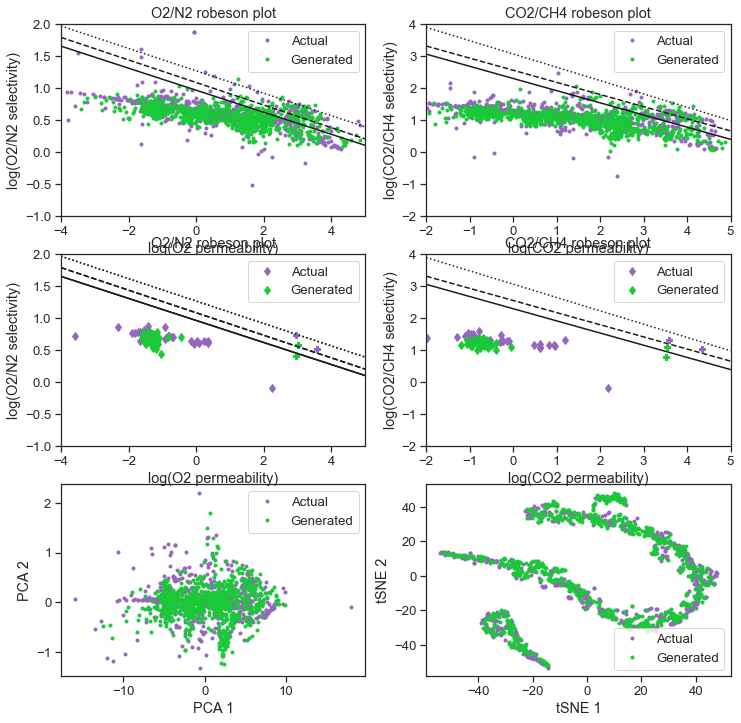

In [64]:
#visualize the generated permeabilities
fig = plt.figure(figsize=(12,12))

#O2/N2 robeson plot
plt.subplot(3,2,1)
permeability = traindata[:,-4]
selectivity = traindata[:,-4] - traindata[:,-3]
plt.plot(permeability, selectivity, '.', color='tab:purple')
permeability = trainpreds[:,-4]
selectivity = trainpreds[:,-4] - trainpreds[:,-3]
plt.plot(permeability, selectivity, '.g')
plt.title("O2/N2 robeson plot")
plt.xlabel('log(O2 permeability)')
plt.ylabel('log(O2/N2 selectivity)')
plt.legend(['Actual', 'Generated'])
xmin = -4
xmax = 5
plt.xlim([xmin, xmax])
plt.ylim([-1, 2])
plt.plot([xmin, xmax], [np.log10(9.2008)-0.1724*xmin, np.log10(9.2008)-0.1724*xmax], '-k') #1991 upper bound
plt.plot([xmin, xmax], [np.log10(12.148)-0.1765*xmin, np.log10(12.148)-0.1765*xmax], '--k') #2008 upper bound
plt.plot([xmin, xmax], [np.log10(18.50)-0.1754*xmin, np.log10(18.50)-0.1754*xmax], ':k') #2015 upper bound

#CO2/CH4 robeson plot
plt.subplot(3,2,2)
permeability = traindata[:,-2]
selectivity = traindata[:,-2] - traindata[:,-1]
plt.plot(permeability, selectivity, '.', color='tab:purple')
permeability = trainpreds[:,-2]
selectivity = trainpreds[:,-2] - trainpreds[:,-1]
plt.plot(permeability, selectivity, '.g')
plt.title('CO2/CH4 robeson plot')
plt.xlabel('log(CO2 permeability)')
plt.ylabel('log(CO2/CH4 selectivity)')
plt.legend(['Actual', 'Generated'])
xmin = -2
xmax =5
plt.xlim([xmin, xmax])
plt.ylim([-2, 4])
plt.plot([xmin, xmax], [np.log10(197.81)-0.3807*xmin, np.log10(197.81)-0.3807*xmax], '-k') #1991 upper bound
plt.plot([xmin, xmax], [np.log10(357.33)-0.3794*xmin, np.log10(357.33)-0.3794*xmax], '--k') #2008 upper bound
plt.plot([xmin, xmax], [np.log10(1155.60)-0.4165*xmin, np.log10(1155.60)-0.4165*xmax], ':k') #2019 upper bound

#pca
plt.subplot(3,2,5)
pca = PCA(n_components=2)
#transformed = pca.fit_transform(traindata)
#plt.plot(transformed[:,0], transformed[:,1], '.', color='tab:purple')
#transformed = pca.fit_transform(trainpreds)
#plt.plot(transformed[:,0], transformed[:,1], '.g')
concatenated = np.append(traindata, trainpreds, axis=0)
transformed = pca.fit_transform(concatenated)
plt.plot(transformed[:778,0], transformed[:778,1], '.', color='tab:purple')
plt.plot(transformed[778:,0], transformed[778:,1], '.g')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.legend(['Actual', 'Generated'])

#tsne
plt.subplot(3,2,6)
tsne = TSNE(n_components=2)
concatenated = np.append(traindata, trainpreds, axis=0)
transformed = tsne.fit_transform(concatenated)
plt.plot(transformed[:778,0], transformed[:778,1], '.', color='tab:purple')
plt.plot(transformed[778:,0], transformed[778:,1], '.g')
plt.xlabel('tSNE 1')
plt.ylabel('tSNE 2')
plt.legend(['Actual', 'Generated'])

#visualize the predicted permeabilities for a single polymer

#identify a polymer in the scrambled dataset
polyeth_cond = smilesdf.iloc[363,:] #choose a polymer from the original dataframe, 0 index is polyethylene
#polyeth_cond = smilesdf.iloc[1,:] #choose a polymer from the original dataframe, 0 index is polyethylene
polyeth_indices = trainconditions_df.where(trainconditions_df == polyeth_cond).dropna().index #indices that correspond to that polymer

#O2/N2 robeson plot
plt.subplot(3,2,3)
permeability = traindata[polyeth_indices,-4]
selectivity = traindata[polyeth_indices,-4] - traindata[polyeth_indices,-3]
plt.plot(permeability, selectivity, 'd', color='tab:purple')
permeability = trainpreds[polyeth_indices,-4]
selectivity = trainpreds[polyeth_indices,-4] - trainpreds[polyeth_indices,-3]
plt.plot(permeability, selectivity, 'gd')
plt.title("O2/N2 robeson plot")
plt.xlabel('log(O2 permeability)')
plt.ylabel('log(O2/N2 selectivity)')
plt.legend(['Actual', 'Generated'])
xmin = -4
xmax = 5
plt.xlim([xmin, xmax])
plt.ylim([-1, 2])
plt.plot([xmin, xmax], [np.log10(9.2008)-0.1724*xmin, np.log10(9.2008)-0.1724*xmax], '-k') #1991 upper bound
plt.plot([xmin, xmax], [np.log10(12.148)-0.1765*xmin, np.log10(12.148)-0.1765*xmax], '--k') #2008 upper bound
plt.plot([xmin, xmax], [np.log10(18.50)-0.1754*xmin, np.log10(18.50)-0.1754*xmax], ':k') #2015 upper bound

#CO2/CH4 robeson plot
plt.subplot(3,2,4)
permeability = traindata[polyeth_indices,-2]
selectivity = traindata[polyeth_indices,-2] - traindata[polyeth_indices,-1]
plt.plot(permeability, selectivity, 'd', color='tab:purple')
permeability = trainpreds[polyeth_indices,-2]
selectivity = trainpreds[polyeth_indices,-2] - trainpreds[polyeth_indices,-1]
plt.plot(permeability, selectivity, 'gd')
plt.title('CO2/CH4 robeson plot')
plt.xlabel('log(CO2 permeability)')
plt.ylabel('log(CO2/CH4 selectivity)')
plt.legend(['Actual', 'Generated'])
xmin = -2
xmax =5
plt.xlim([xmin, xmax])
plt.ylim([-2, 4])
plt.plot([xmin, xmax], [np.log10(197.81)-0.3807*xmin, np.log10(197.81)-0.3807*xmax], '-k') #1991 upper bound
plt.plot([xmin, xmax], [np.log10(357.33)-0.3794*xmin, np.log10(357.33)-0.3794*xmax], '--k') #2008 upper bound
plt.plot([xmin, xmax], [np.log10(1155.60)-0.4165*xmin, np.log10(1155.60)-0.4165*xmax], ':k') #2019 upper bound
plt.title('CO2/CH4 robeson plot')

#identify a different polymer in the scrambled dataset
#polyeth_cond = smilesdf.iloc[363,:] #choose a polymer from the original dataframe, 0 index is polyethylene
polyeth_cond = smilesdf.iloc[690,:] #choose a polymer from the original dataframe, 0 index is polyethylene
polyeth_indices = trainconditions_df.where(trainconditions_df == polyeth_cond).dropna().index #indices that correspond to that polymer

#O2/N2 robeson plot
plt.subplot(3,2,3)
permeability = traindata[polyeth_indices,-4]
selectivity = traindata[polyeth_indices,-4] - traindata[polyeth_indices,-3]
plt.plot(permeability, selectivity, 'P', color='tab:purple')
permeability = trainpreds[polyeth_indices,-4]
selectivity = trainpreds[polyeth_indices,-4] - trainpreds[polyeth_indices,-3]
plt.plot(permeability, selectivity, 'gP')
plt.title("O2/N2 robeson plot")
plt.xlabel('log(O2 permeability)')
plt.ylabel('log(O2/N2 selectivity)')
plt.legend(['Actual', 'Generated'])
xmin = -4
xmax = 5
plt.xlim([xmin, xmax])
plt.ylim([-1, 2])
plt.plot([xmin, xmax], [np.log10(9.2008)-0.1724*xmin, np.log10(9.2008)-0.1724*xmax], '-k') #1991 upper bound
plt.plot([xmin, xmax], [np.log10(12.148)-0.1765*xmin, np.log10(12.148)-0.1765*xmax], '--k') #2008 upper bound
plt.plot([xmin, xmax], [np.log10(18.50)-0.1754*xmin, np.log10(18.50)-0.1754*xmax], ':k') #2015 upper bound

#CO2/CH4 robeson plot
plt.subplot(3,2,4)
permeability = traindata[polyeth_indices,-2]
selectivity = traindata[polyeth_indices,-2] - traindata[polyeth_indices,-1]
plt.plot(permeability, selectivity, 'P', color='tab:purple')
permeability = trainpreds[polyeth_indices,-2]
selectivity = trainpreds[polyeth_indices,-2] - trainpreds[polyeth_indices,-1]
plt.plot(permeability, selectivity, 'gP')
fig.savefig('fmgan_generated.svg', format='svg')

In [17]:
trainconditions_df = pd.DataFrame(trainconditions)

#identify polyethylene in the scrambled dataset
polyeth_cond = smilesdf.iloc[0,:] #choose a polymer from the original dataframe, 0 index is polyethylene
polyeth_indices = trainconditions_df.where(trainconditions_df == polyeth_cond).dropna().index #indices that correspond to that polymer

Dataset1_grouped = Dataset1_Smiles_P.groupby('Smiles').mean().reset_index()

#identify high performance polymers (O2/N2) in the scrambled dataset
highperf = Dataset1_grouped.where(Dataset1_grouped['log10_O2_Bayesian'] - Dataset1_grouped['log10_N2_Bayesian'] > np.log10(12.148) - 0.1765*Dataset1_grouped['log10_O2_Bayesian']).dropna('index','all')

smiles = highperf['Smiles']
smiles_ = [np.array([V.index(c) for c in s] + [V.index(END_TOKEN)]).astype(np.int32) for s in smiles]
highperf_smilesdf = pd.DataFrame(smiles_, index=smiles.index)
highperf_smilesdf = highperf_smilesdf.fillna(value=V.index(NULL_TOKEN))
highperf_smilesdf = highperf_smilesdf.astype('int32')

highperf_ON_indices =[]
for i in range(highperf_smilesdf.shape[0]):
    highperf_ON_indices += (list(trainconditions_df.where(trainconditions_df == highperf_smilesdf.iloc[i,:]).dropna().index)) #indices that correspond to that polymer
highperf_ON_indices = np.sort(highperf_ON_indices)

#do the same with high perforamnce CO2/CO4 polymers
highperf = Dataset1_grouped.where(Dataset1_grouped['log10_CO2_Bayesian'] - Dataset1_grouped['log10_CH4_Bayesian'] > np.log10(357.33)-0.3794*Dataset1_grouped['log10_CO2_Bayesian']).dropna('index','all')

smiles = highperf['Smiles']
smiles_ = [np.array([V.index(c) for c in s] + [V.index(END_TOKEN)]).astype(np.int32) for s in smiles]
highperf_smilesdf = pd.DataFrame(smiles_, index=smiles.index)
padding = pd.DataFrame(index=smiles.index, columns=np.arange(124,191))
highperf_smilesdf = pd.concat([highperf_smilesdf, padding], axis=1)
highperf_smilesdf = highperf_smilesdf.fillna(value=V.index(NULL_TOKEN))
highperf_smilesdf = highperf_smilesdf.astype('int32')

highperf_CC_indices =[]
for i in range(highperf_smilesdf.shape[0]):
    highperf_CC_indices += (list(trainconditions_df.where(trainconditions_df == highperf_smilesdf.iloc[i,:]).dropna().index)) #indices that correspond to that polymer
highperf_CC_indices = np.sort(highperf_CC_indices)


In [35]:
#embed the new data to visualize it in relation to the embeded data
#feed in batches to avoid too much data
embconds_dataset3 = np.zeros((Dataset3.shape[0], MAX_LENGTH))
#embconds_dataset3 = np.zeros((100000, MAX_LENGTH))
for i in range(9):
    feed = {x: batch_x, condition: allsmilesdf.to_numpy()[i*100000:(i+1)*100000,:MAX_LENGTH], z: batchz, tfis_training: True}
    embconds_dataset3[i*100000:(i+1)*100000,:] = sess.run(embedded_condition_G, feed_dict=feed)
feed = {x: batch_x, condition: allsmilesdf.to_numpy()[900000:,:MAX_LENGTH], z: batchz, tfis_training: True}
embconds_dataset3[900000:,:] = sess.run(embedded_condition_G, feed_dict=feed)

#concatenate the training embeddings with those from the highthroughput screening 
all_embeddings = np.concatenate((trainembconditions, embconds_dataset3))

In [56]:
#calculate embedings for dataset2 then concatenate
embconds_dataset2 = np.zeros((Dataset2.shape[0], MAX_LENGTH))
feed = {x: batch_x, condition: smilesdf2.to_numpy()[:,:MAX_LENGTH], z: batchz, tfis_training: True}
embconds_dataset2 = sess.run(embedded_condition_G, feed_dict=feed)
all_embeddings2 = np.concatenate((trainembconditions, embconds_dataset2))

NameError: name 'x' is not defined

Text(0, 0.5, 'tSNE 2')

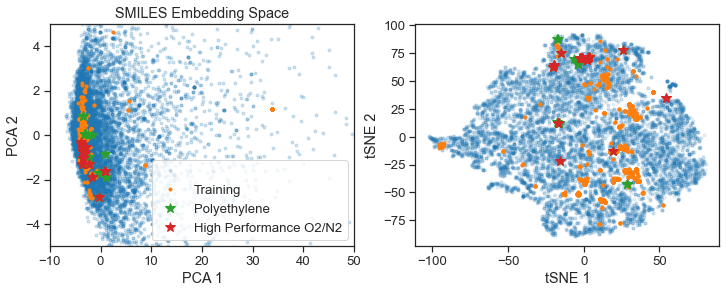

In [71]:
#visualize the embedding space in pca, highlight the high performance polymers
sns.set_palette('tab10')
figure = plt.figure(figsize=(12,9))
figure.tight_layout()
plt.subplot(2,2,1)
pca = PCA(n_components=2)
a = 0.2
transformed = pca.fit_transform(all_embeddings2)
plt.plot(transformed[:,0], transformed[:,1], '.', alpha=a)
plt.plot(transformed[:778,0], transformed[:778,1], '.', alpha=1)
#plt.plot(transformed[polyeth_indices,0], transformed[polyeth_indices,1], '.', alpha=1)
plt.plot(transformed[highperf_ON_indices,0], transformed[highperf_ON_indices,1], '*', markersize=10)
plt.plot(transformed[highperf_CC_indices,0], transformed[highperf_CC_indices,1], '*', markersize=10)
plt.title("SMILES Embedding Space")
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.xlim([-10,50])
plt.ylim([-5,5])
plt.legend([None,'Training','Polyethylene', 'High Performance O2/N2', 'High Performance CO2/CH4'])

#visualize the embedding space in tsne, highlight the high performance polymers
plt.subplot(2,2,2)
tsne = TSNE(n_components=2)
transformed = tsne.fit_transform(all_embeddings2)
plt.plot(transformed[:,0], transformed[:,1], '.', alpha=0.1)
plt.plot(transformed[:778,0], transformed[:778,1], '.')
#plt.plot(transformed[polyeth_indices,0], transformed[polyeth_indices,1], '.')
plt.plot(transformed[highperf_ON_indices,0], transformed[highperf_ON_indices,1], '*', markersize=10)
plt.plot(transformed[highperf_CC_indices,0], transformed[highperf_CC_indices,1], '*', markersize=10)
plt.xlabel('tSNE 1')
plt.ylabel('tSNE 2')

In [73]:
figure.savefig('fmgan_embeddingspace.eps', format='eps')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

In [40]:
#save the results from FMGAN training
pd.DataFrame(traindata).to_csv("FMGAN_traindata.csv", header=None, index=None)
pd.DataFrame(trainconditions).to_csv("FMGAN_trainconditions.csv", header=None, index=None)
pd.DataFrame(trainpreds).to_csv("FMGAN_trainpreds.csv", header=None, index=None)
pd.DataFrame(trainembconditions).to_csv("FMGAN_trainembconditions.csv", header=None, index=None)
pd.DataFrame(MMDs).to_csv("FMGAN_MMDs.csv", header=None, index=None)
pd.DataFrame(embconds_dataset3).to_csv("FMGAN_dataset3embconditions.csv", header=None, index=None)
pd.DataFrame(embconds_dataset2).to_csv("FMGAN_dataset2embconditions.csv", header=None, index=None)

In [13]:
#load the results from FMGAN training for visualization
traindata = pd.read_csv('FMGAN_traindata.csv').values
trainconditions = pd.read_csv('FMGAN_trainconditions.csv').values
trainembconditions = pd.read_csv('FMGAN_trainembconditions.csv').values
trainpreds = pd.read_csv('FMGAN_trainpreds.csv').values
MMDs = pd.read_csv('FMGAN_MMDs.csv').values
embconds_dataset3 = pd.read_csv('FMGAN_dataset3embconditions.csv').values
embconds_dataset2 = pd.read_csv('FMGAN_dataset2embconditions.csv').values

In [148]:
#rank the polymers in dataset2 by the distant to the high performance polymers in the embedding space
all_embeddings2 = np.concatenate((trainembconditions, embconds_dataset2))
mean_embCC = np.mean(trainembconditions[highperf_CC_indices,:], axis=0)
mean_embON = np.mean(trainembconditions[highperf_ON_indices,:], axis=0)

difference = mean_embCC - embconds_dataset2 
distances = np.array([])
for row in difference:
    distances = np.append(distances, np.dot(row, row))
Dataset2['CCdist'] = distances
difference = mean_embON - embconds_dataset2 
distances = np.array([])
for row in difference:
    distances = np.append(distances, np.dot(row, row))
distances.shape
Dataset2['ONdist'] = distances
Dataset2_sorted = Dataset2.sort_values(['CCdist','ONdist'])
Dataset2_top = Dataset2_sorted.iloc[:20,:]
Dataset2_top
Dataset2_top.to_csv('dataset2top_FMGAN_polymers.csv')

C:\Users\jason\Anaconda3\envs\my-rdkit-env\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\jason\Anaconda3\envs\my-rdkit-env\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


,Unnamed: 0,Smiles,ID,CCdist,ONdist
0,0,*C*,P010001.mol,42279.890625,42047.769531
1,1,*C(C*)C,P010002.mol,108.350433,100.528603
2,2,*C(C*)CC,P010003.mol,28.267551,29.073189
3,3,*C(C*)CCC,P010004.mol,27.722126,28.558550
4,4,*C(C*)C(C)C,P010006.mol,26.179337,28.596058
...,...,...,...,...,...
12609,12609,*c1c2ccccc2c2ccccc2c1*,P522051.mol,97.106796,90.479538
12610,12610,*c1c2ccc3ccc(c4ccc(c(c1)C#C)c2c34)*,P522052.mol,121.403214,113.676697
12611,12611,*c1c2ccc3ccc(c4ccc(c(c1)C#CC=C)c2c34)*,P522053.mol,203.022903,190.818130
12612,12612,*c1c2ccc3ccc(c4ccc(c(c1)C#CC#C[Si](C)(C)C)c2c34)*,P522054.mol,344.861389,328.378967


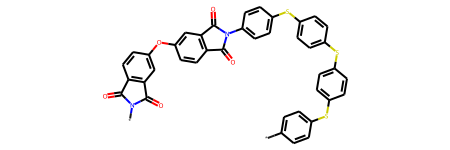

In [239]:
mols = Dataset2_sorted['Smiles'].apply(Chem.MolFromSmiles)
mols.to_numpy()[1]

In [185]:
#rank the polymers in dataset3 by the distant to the high performance polymers in the embedding space
difference = mean_embCC - embconds_dataset3 
distances = np.array([])
for row in difference:
    distances = np.append(distances, np.dot(row, row))
Dataset3['CCdist'] = distances
difference = mean_embON - embconds_dataset3 
distances = np.array([])
for row in difference:
    distances = np.append(distances, np.dot(row, row))
distances.shape
Dataset3['ONdist'] = distances

Dataset3_sorted = Dataset3.sort_values(['ONdist','CCdist'])
#Dataset3_sorted.to_csv('FMGAN_dataset3_embdistances.csv')
Dataset3_top = Dataset3_sorted.iloc[:20,:]
Dataset3_top
Dataset3_top.to_csv('dataset3top_FMGAN_polymers.csv')

,SMILES,CCdist,ONdist
0,*CCC[Fe]CCCC(=O)OCCCCOCCCNCC(*)=O,641.450620,616.473502
1,*CCCC1C=CNC2=CC=C2C(*)CCC1,29.363601,30.931018
2,*CCC*,1402.496961,1365.403530
3,*C(=O)CNC(*)C(=O)OCCCCCNC,23.957034,28.229932
4,*CC(C)(C)CCCCCCC(C)C(=O)N*,22.171303,21.908209
...,...,...,...
995794,*CC(*)(CCC(=O)Oc1ccc(/N=N/c2ccc(C#N)cc2)cc1)c1...,1868.415202,1822.068670
995795,*Oc1ccccc1NC(=O)c1ccc(/N=N/c2ccc(C(=O)OC(=O)CC...,25.509308,26.966621
995796,*NC(CC)CC(=O)NCCCCCCNS(*)(=O)=O,84.833068,80.730822
995797,*CCN(CCOC(=O)NCCCCCCCCNC(=O)O*)CC(=O)OC,21.509311,22.284996


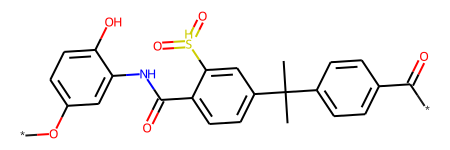

In [236]:
mols = Dataset3_top['SMILES'].apply(Chem.MolFromSmiles)
mols.to_numpy()[0]